# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

In [44]:
#first installing requirments
# !pip install optuna
# !pip install colorama
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# !pip install Albumentations
#!unzip triple_mnist\ \(1\).zip
!unzip svhn.zip
!pip install category_encoders

Archive:  svhn.zip
   creating: svhn/
 extracting: svhn/111.png            
 extracting: svhn/113.png            
 extracting: svhn/114.png            
 extracting: svhn/116.png            
  inflating: svhn/120.png            
 extracting: svhn/124.png            
 extracting: svhn/128.png            
  inflating: svhn/129.png            
  inflating: svhn/130.png            
 extracting: svhn/132.png            
 extracting: svhn/136.png            
 extracting: svhn/138.png            
 extracting: svhn/140.png            
 extracting: svhn/144.png            
 extracting: svhn/148.png            
 extracting: svhn/150.png            
 extracting: svhn/151.png            
 extracting: svhn/153.png            
 extracting: svhn/157.png            
  inflating: svhn/158.png            
 extracting: svhn/159.png            
 extracting: svhn/164.png            
 extracting: svhn/165.png            
 extracting: svhn/166.png            
 extracting: svhn/171.png            
 extracting:

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from tqdm.notebook import tqdm

# preparing dataset

class Task1Dataset(torch.utils.data.Dataset):
  '''
  Prepare the Data for regression
  '''
  def __init__(self):
    df = pd.read_csv("Task 1.csv")
    X = df.drop(["math score", "writing score", "reading score"], axis=1)
    y = df[["math score", "writing score", "reading score"]].to_numpy(dtype='float32')

    ohe = OneHotEncoder(drop="if_binary", sparse=False)
    X = ohe.fit_transform(X)
    X = X.astype('float32')
    self.x = torch.from_numpy(X) 
    self.y = torch.from_numpy(y)
    self.n_samples = X.shape[0]

  def __len__(self):
      return self.n_samples

  def __getitem__(self, i):
      return self.x[i], self.y[i]




dataset = Task1Dataset()

batch_size = 64
test_split = 0.2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and testing splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=val_sampler)


In [10]:
# based on https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
# based on https://broutonlab.com/blog/efficient-hyperparameter-optimization-with-optuna-framework
# based on https://colab.research.google.com/drive/1OegNO802ZrluOqO4upRhy9OYiIH6KG6k?usp=sharing

import optuna
from optuna.trial import TrialState
DEVICE = torch.device("cpu")
N_TRAIN_EXAMPLES = batch_size * 30
N_VALID_EXAMPLES = batch_size * 10
EPOCHS=10
CLASSES = 3

def define_model(trial, n_layers, activation_function):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    layers = []

    in_features = 14
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 3, 64)
        layers.append(nn.Linear(in_features, out_features))

        if activation_function == "ReLU":
            layers.append(nn.ReLU())
        elif activation_function == "Leaky ReLU":
            layers.append(nn.LeakyReLU())
        elif activation_function == "Softmax":
            layers.append(nn.Softmax())

        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))

    return nn.Sequential(*layers)



def objective(trial):

    #hyperparameters we want to optimize
    params = {
        "optimizer" : trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
        "lr" : trial.suggest_float("lr", 1e-5, 1e-1, log=True),
        "n_layers" : trial.suggest_int("n_layers", 1, 3, 5),
        "activation_function" : trial.suggest_categorical("activation_function", ["ReLU", "Softmax", "Leaky ReLU"])
    }

    # Generate the model.
    model = define_model(trial, params["n_layers"], params["activation_function"]).to(DEVICE)

    # Generate the optimizers.
    optimizer = getattr(optim, params["optimizer"])(model.parameters(), lr=params["lr"])



    # Training of the model.
    l1_loss_train = nn.L1Loss()
    
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = l1_loss_train(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        loss_sum = 0

        l1_loss_eval = nn.L1Loss()

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                # Limiting validation data.
                # if batch_idx * batch_size >= N_VALID_EXAMPLES:
                #     break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            
                optimizer.zero_grad()
                output = model(data)
                loss_eval = l1_loss_eval(output, target)
                loss_sum += l1_loss_eval(output,target).item()
                loss_eval.requires_grad = True
                loss_eval.backward()
                optimizer.step()
                

        val_loss = loss_sum / min(len(val_loader), N_VALID_EXAMPLES)

        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss



study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=60)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-23 13:53:42,810] A new study created in memory with name: no-name-275ba7df-5602-4db9-a776-3d928c183dab
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:686: UserWarning: The distribution is specified by [1, 3] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 1].
  low=low, old_high=old_high, high=high, step=step
[I 2022-11-23 13:53:43,322] Trial 0 finished with value: 14.129116773605347 and parameters: {'optimizer': 'Adam', 'lr': 0.0036531776882024586, 'n_layers': 1, 'activation_function': 'ReLU', 'n_units_l0': 58, 'dropout_l0': 0.30560816379427375}. Best is trial 0 with value: 14.129116773605347.
[I 2022-11-23 13:53:43,548] Trial 1 finished with value: 68.9507064819336 and parameters: {'optimizer': 'RMSprop', 'lr': 7.647214226996734e-05, 'n_layers': 1, 'activation_function': 'Leaky ReLU', 'n_units_l0': 28, 'dropout_l0': 0.2334651230957204}. Best is trial 0 with value: 14.129116773605347.
/usr/local/lib/python3.7/dist-packages/to

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  44
  Number of complete trials:  56
Best trial:
  Value:  9.891558408737183
  Params: 
    optimizer: RMSprop
    lr: 0.015812001726109734
    n_layers: 1
    activation_function: ReLU
    n_units_l0: 63
    dropout_l0: 0.45829372484450015



### Questions
1. What preprocessing techniques did you use? Why?
    - I have used One hot encoder for categorical data. Since it was the least encoding to have any bias to the data. take for example parental education, I didnt want to put more weight to a higher degree.  
    - used "if_binary" since there is no need to have two columns for binary features.
2. Describe the fine-tuning process and how you reached your model architecture.
    - I have used optuna to choose number of layers and activation function

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

In [67]:
# based on https://medium.com/swlh/multi-digit-sequence-recognition-with-crnn-and-ctc-loss-using-pytorch-framework-269a7aca2a6

import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from colorama import Fore
from torchvision import datasets, transforms
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from PIL import Image
import time

gpu = torch.device('cpu')
# ============================================= PREPARING DATASET ======================================================


epochs = 10
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 2
cnn_output_width = 32
digits_per_sequence = 3


def get_paths(filepath):
    paths = []

    for folder in os.listdir(filepath):
        subfolder = os.path.join(filepath, folder)
        for filename in os.listdir(subfolder):
            path = os.path.join(subfolder, filename)
            paths.append(path)

    return paths


def prepare_dataset(paths):
    data_seq = []
    labels = []

    for f in paths:
        img = Image.open(f)
        img = img.resize((28, 84))
        np_img = np.asarray(img)
        data_seq.append(np_img)
        label = f.split("/")[3].split("_")[1][:3]
        label = [int(x) for x in label]
        label = np.array(label)
        labels.append(label)

    return data_seq, labels


test_paths = get_paths("triple_mnist/test")
train_paths = get_paths("triple_mnist/train")
val_paths = get_paths("triple_mnist/val")

data_seq, labels = prepare_dataset(train_paths)
dataset_data = torch.Tensor(np.array(data_seq))
dataset_labels = torch.IntTensor(np.array(labels))
train_set = data_utils.TensorDataset(dataset_data, dataset_labels)

data_seq, labels = prepare_dataset(test_paths)
dataset_data = torch.Tensor(np.array(data_seq))
dataset_labels = torch.IntTensor(np.array(labels))
test_set = data_utils.TensorDataset(dataset_data, dataset_labels)

data_seq, labels = prepare_dataset(val_paths)
dataset_data = torch.Tensor(np.array(data_seq))
dataset_labels = torch.IntTensor(np.array(labels))
val_set = data_utils.TensorDataset(dataset_data, dataset_labels)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


In [43]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)

        # Spicing up an otherwise dull CNN :)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out


model = CRNN().to("cpu")
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ================================================ TRAINING MODEL ======================================================
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train)
        y_pred = y_pred.permute(1, 0, 2)  
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2) 
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

# ============================================ TESTING =================================================================
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)



100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]
TRAINING. Correct:  14220 / 64000 = 0.2221875
100%|██████████| 250/250 [00:50<00:00,  4.94it/s]
TESTING. Correct:  11795 / 16000 = 0.7371875
100%|██████████| 1000/1000 [09:52<00:00,  1.69it/s]
TRAINING. Correct:  54831 / 64000 = 0.856734375
100%|██████████| 250/250 [00:52<00:00,  4.75it/s]
TESTING. Correct:  14073 / 16000 = 0.8795625
100%|██████████| 1000/1000 [09:19<00:00,  1.79it/s]
TRAINING. Correct:  58889 / 64000 = 0.920140625
100%|██████████| 250/250 [00:51<00:00,  4.90it/s]
TESTING. Correct:  14490 / 16000 = 0.905625
100%|██████████| 1000/1000 [09:44<00:00,  1.71it/s]
TRAINING. Correct:  60177 / 64000 = 0.940265625
100%|██████████| 250/250 [00:51<00:00,  4.84it/s]
TESTING. Correct:  14772 / 16000 = 0.92325
100%|██████████| 1000/1000 [09:43<00:00,  1.72it/s]
TRAINING. Correct:  60883 / 64000 = 0.951296875
100%|██████████| 250/250 [00:50<00:00,  4.91it/s]
TESTING. Correct:  14823 / 16000 = 0.9264375
100%|██████████| 1000/1000 [09

In [72]:
# see how much time it will take to predict 50 image
from datetime import datetime

loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True)

model.eval()
start = datetime.now()
end = 0
for x_val,y_val in loader:
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
        end = datetime.now()
        break

print(f"Time taken to predict 50 images {end - start}")


Time taken to predict 50 images 0:00:00.264112


### Questions
1. What preprocessing techniques did you use? Why?
    - just resizing and changing them into tensors, There were no apperant need to anything more since we have enough samples and images are simple enough by themselves. Also, from the model's metrics, there is no need to do anymore processing 
2. What data augmentation techniques did you use?
    - pretty much same as above
3. Describe the fine-tuning process and how you reached your final CNN model.
    - Well, first I though of having a 1k neurons, which is abit insane, then thought about 30 neurons which is abit lame. another more promising approaching was either to prepross the images in a certain way to only predict one digit at a time, either by drawing contours or by passing some kind of a sliding window over the image. However, that would have required way too much preprocessing. which made me think of more simpler solution, just adding a recurrent layer ontop of our CNN. Thus we are able to predict the sequence.
    - Regarding finetuning, it was through trail and error, binge reading articles and comparing with my collegues metrics. I would say my model archticture outperforms their models since it takes less than 2 hours using all the datasets and got 94% accuracy, compared to theirs which takes more than 5 hours. and both models comparable results. 
    - one last thing, I believe the architecture will be easily edited to handle higher sequence of numbers, not only 3 digits

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Decision Tree
Fitting 4 folds for each of 50 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       374
           1       0.99      0.99      0.99      1542

    accuracy                           0.99      1916
   macro avg       0.98      0.98      0.98      1916
weighted avg       0.99      0.99      0.99      1916

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5)
Random Forest
Fitting 4 folds for each of 25 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       374
           1       0.98      1.00      0.99      1542

    accuracy                           0.98      1916
   macro avg       0.99      0.97      0.98      1916
weighted avg       0.98      0.98      0.98      1916

RandomForestClassifier(max_depth=20, min_samples_leaf=5)


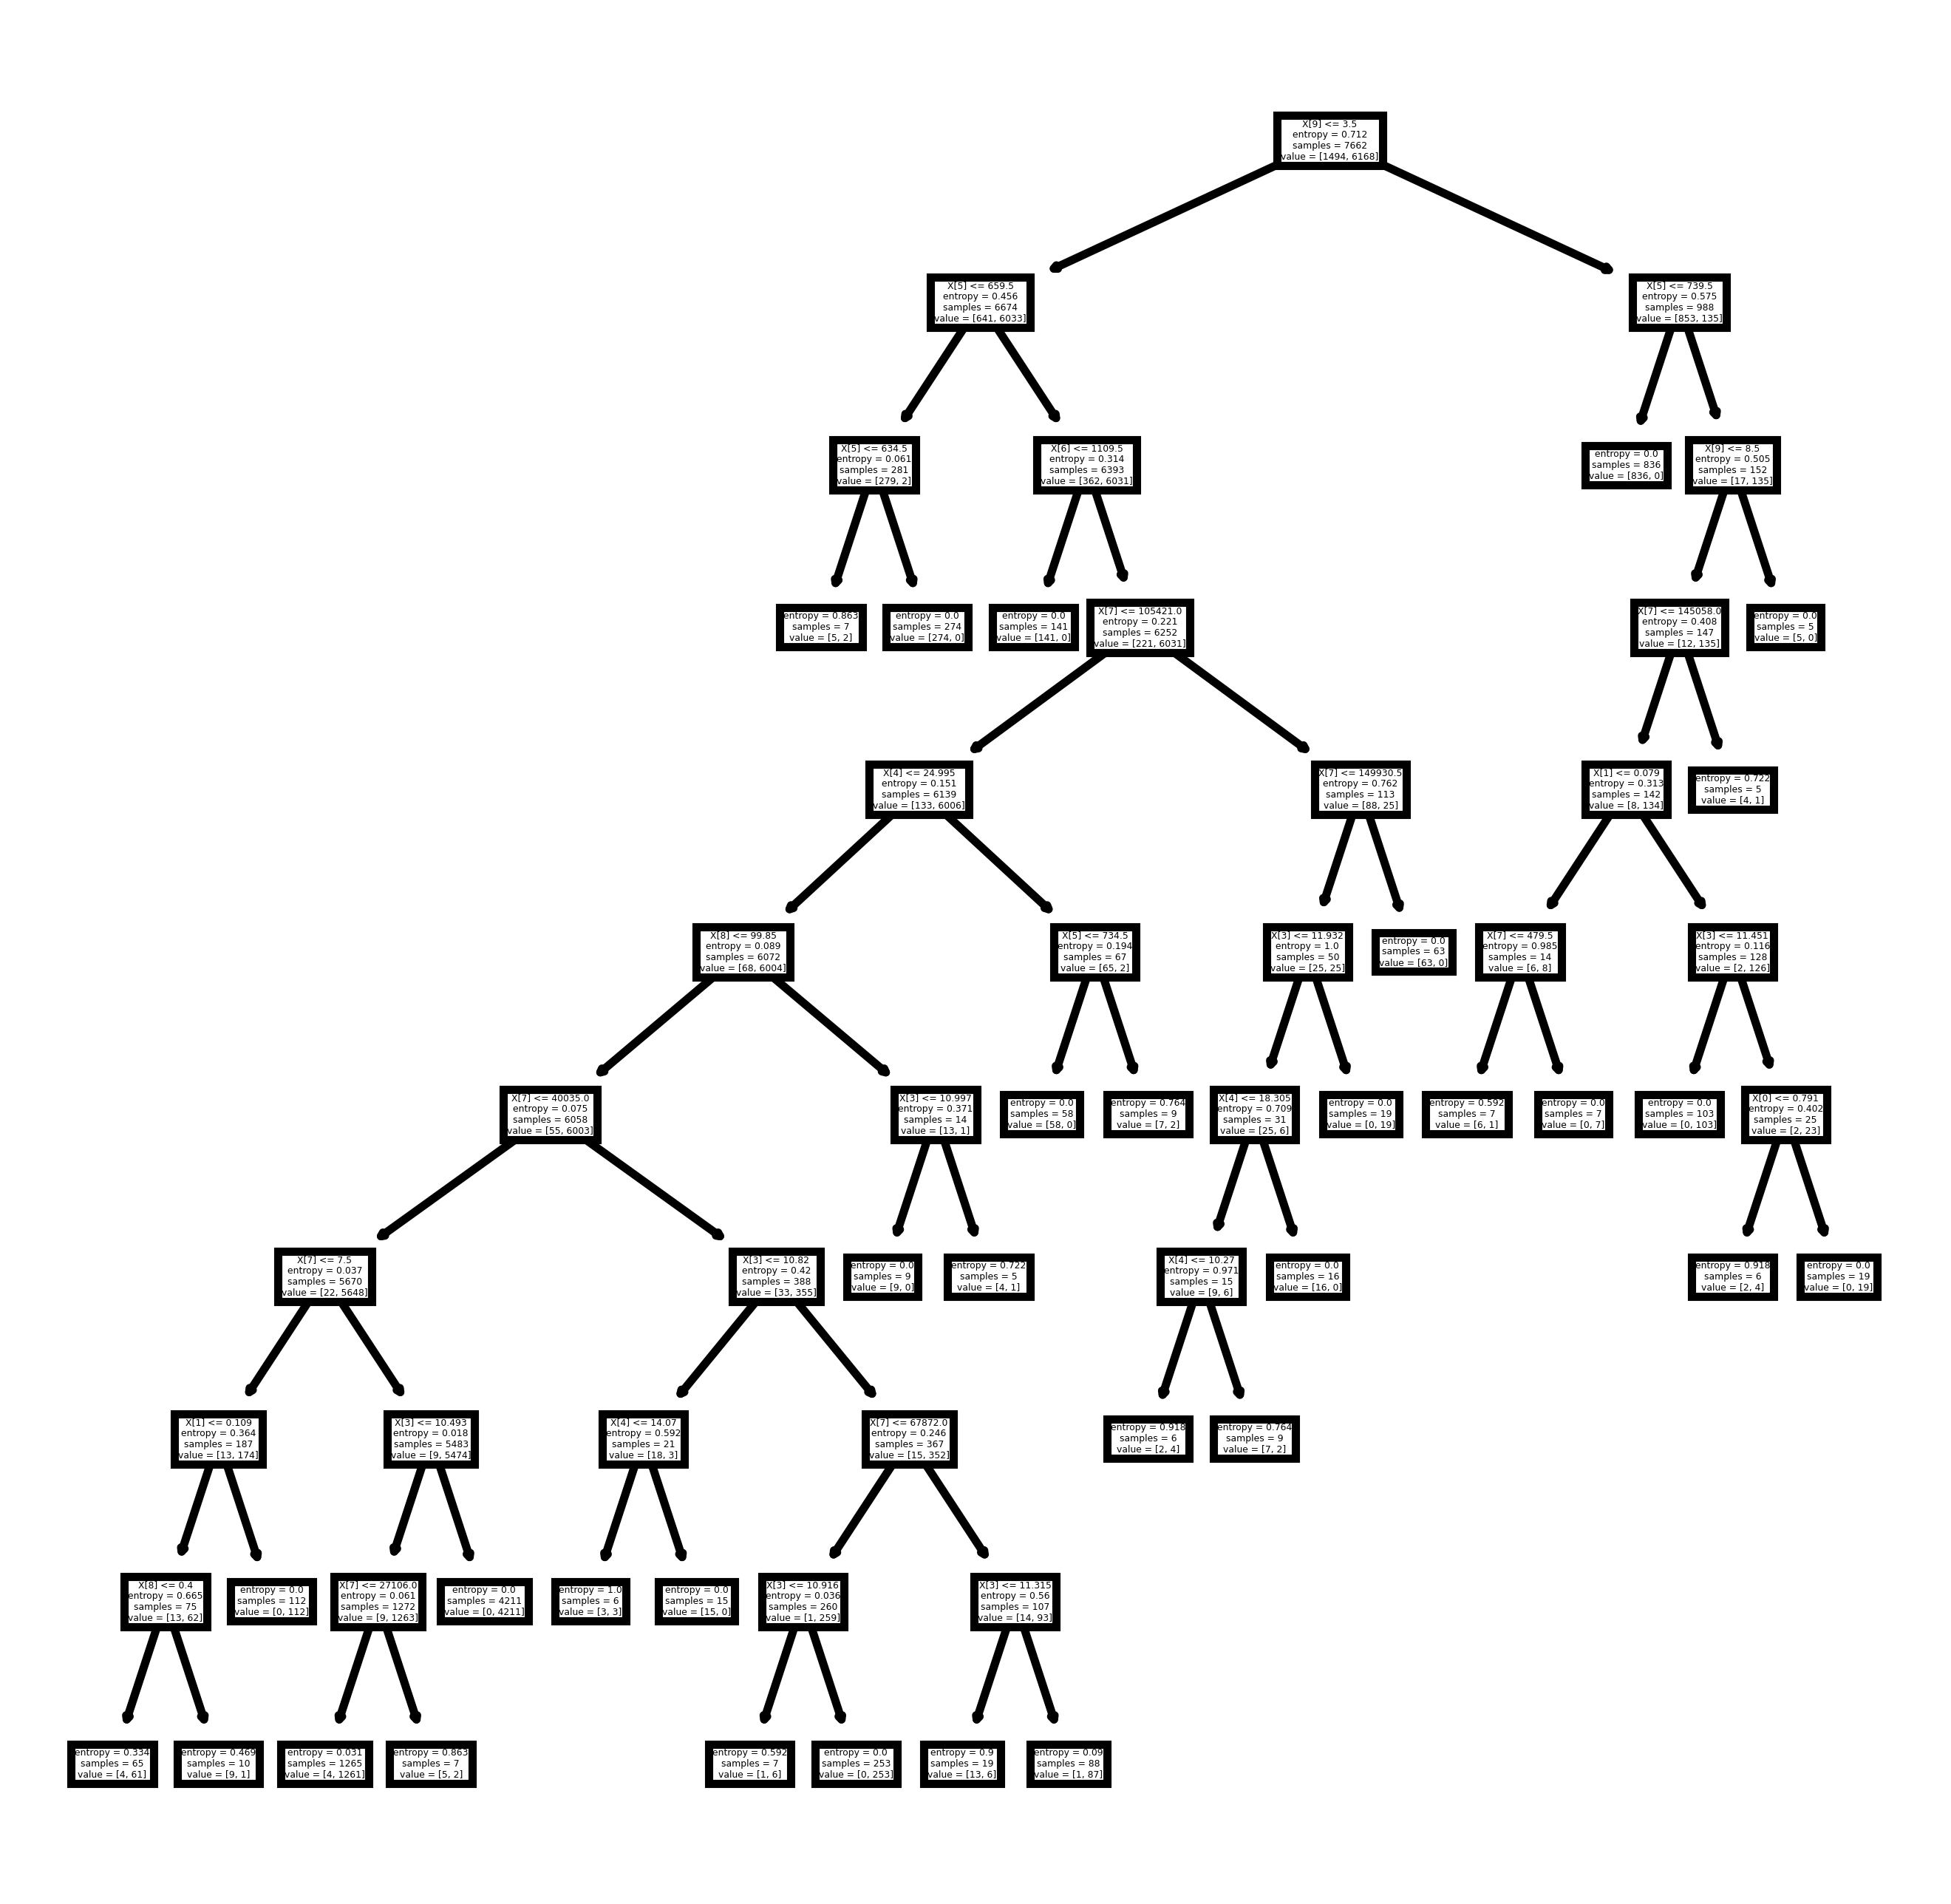

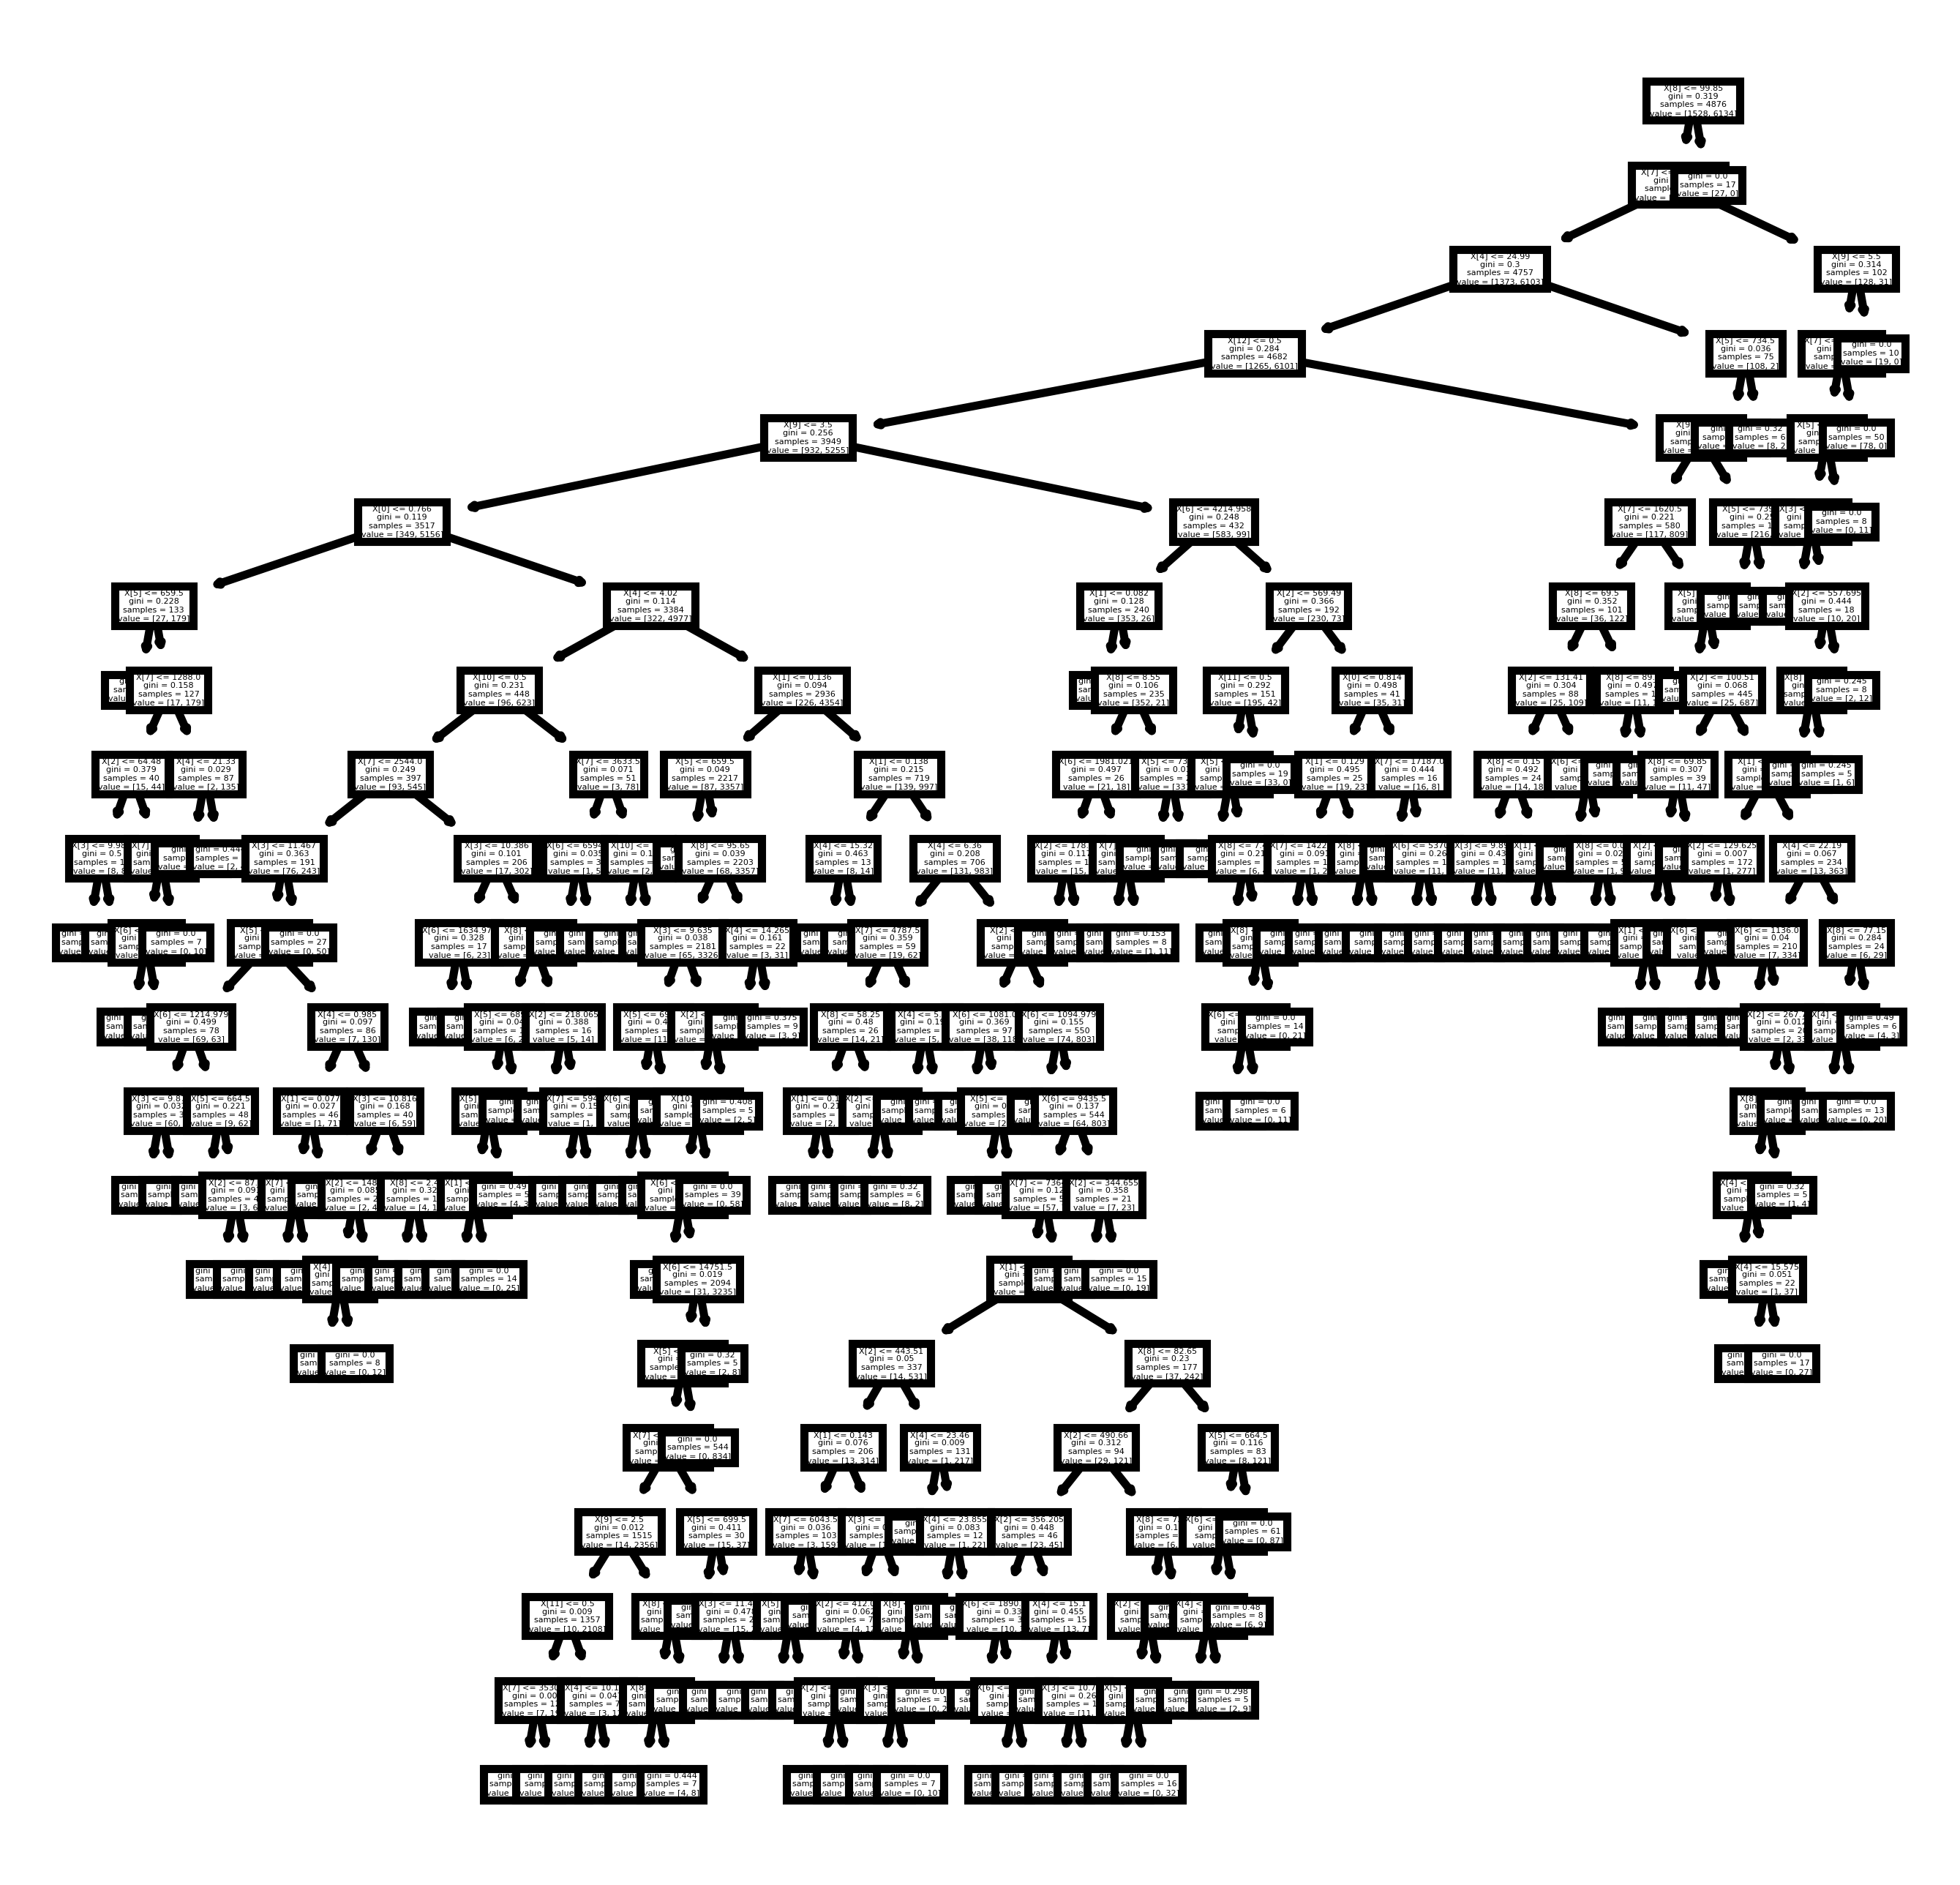

In [73]:
!pip install category_encoders
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import matplotlib.pyplot as plt



#preparing data
df = pd.read_csv("loan_data.csv")
X_train, X_test, y_train, y_test = train_test_split( df.drop(["credit.policy"], axis=1), df["credit.policy"], test_size=0.2,
                                                    random_state=42, stratify=df["credit.policy"])
encoder = TargetEncoder()
encoder.fit(X_train["purpose"], y_train)
X_train["purpose"] =  encoder.transform(X_train["purpose"])
X_test["purpose"] = encoder.transform(X_test["purpose"])


def grid_search(estimator, params, name):
  print(name)

  gs = GridSearchCV(estimator=estimator, 
                    param_grid = params,
                     cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
  gs.fit(X_train, y_train)
  pred = gs.predict(X_test)
  print(classification_report(y_true=y_test, y_pred=pred))
  print(gs.best_estimator_)

  #visulizing the tree
  fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
  if name == "Random Forest":
    tree.plot_tree(gs.best_estimator_[0])
  else:
    tree.plot_tree(gs.best_estimator_)


dtc = DecisionTreeClassifier() 
rfc = RandomForestClassifier()

#params grid for decision tree, inspired from https://www.kaggle.com/code/gauravduttakiit/hyperparameter-tuning-in-decision-trees
params_dt = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}


#param grid for random forest, inspired from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
params_rf = {
    'max_depth' : [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],

}

grid_search(dtc, params_dt, name="Decision Tree")

grid_search(rfc, params_rf, name="Random Forest")



### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer* DT was abit faster than RF, and that is due to the difference in their depth.Both of their metrics are very close. However, by taking a closer look on recall score, we find that the recall of the RF is smaller that DT. 
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - DT max depth is smaller that RF. the first is 10 while the later is 20. I believe that is due to prunning. since the construction procedure for decision trees usually includes pruning, which is a part that is done a posteriori in order to reduce the depth and avoid overfitting. Random Forest does not use this method, as it actually takes advantage of the high variance of the overfitted decision trees by averaging them.
3. What is ensemble learning? What are its pros and cons?
    - Ensemble learning is the combination of predictions from different models. they don't have to be from same class. It relies on "Wisdom of the crowds"
    - pros: combining predections could overcome bias and/or variance.Robustness: An ensemble reduces the spread or dispersion of the predictions and model performance
    - cons: harder to explain to decision makers. Higher costs to creat, train and deploy

4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Boosting*:
        - AdaBoost: uses weak learners in the form of decision trees, which mostly include one split that is popularly known as decision stumps. AdaBoost’s main decision stump comprises observations carrying similar weights.
        - Gradient boosting: adds predictors sequentially to the ensemble, where preceding predictors correct their successors, thereby increasing the model’s accuracy. New predictors are fit to counter the effects of errors in the previous predictors. The gradient of descent helps the gradient booster identify problems in learners’ predictions and counter them accordingly.
    - *Bagging*:
        - *bootstrapping*: is a sampling technique where samples are derived from the whole population (set) using the replacement procedure. The sampling with replacement method helps make the selection procedure randomized. The base learning algorithm is run on the samples to complete the procedure
        - *Aggregation*: in bagging is done to incorporate all possible outcomes of the prediction and randomize the outcome. Without aggregation, predictions will not be accurate because all outcomes are not put into consideration. Therefore, the aggregation is based on the probability bootstrapping procedures or on the basis of all outcomes of the predictive models.


**based on**


 https://corporatefinanceinstitute.com/resources/data-science/ensemble-methods/#:~:text=Bagging%20is%20classified%20into%20two,make%20the%20selection%20procedure%20randomized.
 
https://stackoverflow.com/questions/59756890/a-random-forest-with-one-tree-performs-worse-than-a-single-decision-tree

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [62]:
# TODO: Implement task 4

#prepare dataset
data_seq = []
labels = []

for filename in os.listdir("svhn"):

    img = Image.open(f"svhn/{filename}").convert('L')
    img = img.resize((28,84))
    np_img = np.asarray(img)
    data_seq.append(np_img)
    label = filename.split(".")[0]
    label = [int(x) for x in label]
    label = np.array(label)
    labels.append(label)

dataset_data = torch.Tensor(np.array(data_seq))
dataset_labels = torch.IntTensor(np.array(labels))
val_set = data_utils.TensorDataset(dataset_data, dataset_labels)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)



#evalualting the model
model.eval()
val_correct = 0
val_total = 0
for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val)
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)


100%|██████████| 2/2 [00:00<00:00,  6.03it/s]
TESTING. Correct:  0 / 92 = 0.0


### Questions
1. How did your model perform? Why is it better/worse?
    - It performed worse. I believe that is due to more noise in the svhn data.
2. What is domain gap in the context of ML?
    - When a model performs well on a specific data but when used on another data but from same problem it doesnt do well. for example what we have seen here in model performance when trained on MNIST dataset then used on SVHN dataset. 

3. Suggest two ways through which the problem of domain gap can be tackled.
    - by direct transfer between one domain and the other, when two domains are similar to each other (one-step domain adaptation), or step by step, going from one domain to another through several intermediate domains, in the case of little similarity between the source and the target (multi-step domain adaptation)

**Citation**
https://towardsdatascience.com/object-detection-algorithms-cross-domain-object-detection-e87d3cfd3045
